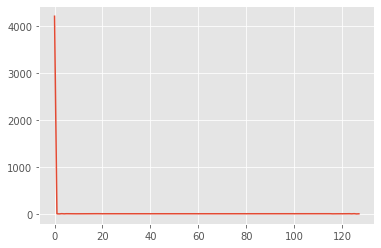

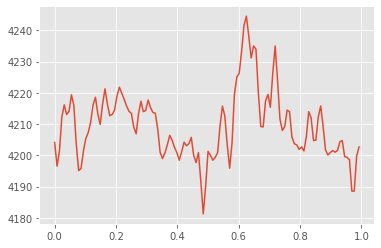

In [60]:
import pandas as pd
import numpy as np

file_names = ['data/data_16/15_data_1_label0.csv',
              'data/data_1.csv']

data = pd.read_csv(file_names[0])
data.columns = range(14)

sample_0 = data[13].iloc[1000:1128]
t = np.arange(128)

Fs = 128.0;  # sampling rate
#Ts = len(snippet)/Fs/Fs; # sampling interval
snippet_time = 128/Fs
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,snippet_time,Ts) # time vector

# ff = 5;   # frequency of the signal
# y = np.sin(2*np.pi*ff*t)
y = sample_0
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
#Y = Y[range(n//2)]


plt.plot(frq, Y)
plt.show()
plt.plot(t, sample_0)
plt.show()

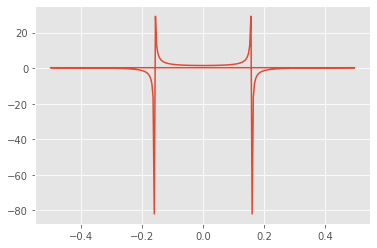

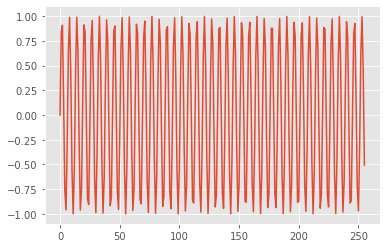

In [16]:
import matplotlib.pyplot as plt
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real)
plt.show()
plt.plot(t, np.sin(t))
plt.show()

In [1]:
from eeg_learn_functions import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [3]:
theta = (4,8)
alpha = (8,14)
beta = (14,40)

In [4]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [5]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [6]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = 100# Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [7]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = 100 # Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [8]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [9]:
from sklearn.preprocessing import scale

def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap, train = True, scaler_list_dump_list = []):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    #scaler_list_dump_list = []
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',')
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        if(not train):
            images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False, train=train, scaler_list_dump = scaler_list_dump_list[i])
        else:
            images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False, train=train)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
    X_r = X[:,:,:,0].reshape((X.shape[0]*image_size, image_size))
    X_g = X[:,:,:,1].reshape((X.shape[0]*image_size, image_size))
    X_b = X[:,:,:,2].reshape((X.shape[0]*image_size, image_size))
    
    #X[:,:,:,0] = scale(X_r, axis = 0).reshape((X.shape[0], X.shape[1], X.shape[2])) 
    #X[:,:,:,1] = scale(X_g, axis = 0).reshape((X.shape[0], X.shape[1], X.shape[2])) 
    #X[:,:,:,2] = scale(X_b, axis = 0).reshape((X.shape[0], X.shape[1], X.shape[2])) 
    #scaler_Xr = StandardScaler(with_mean = 0.5, with_std = 0.5).fit(X_r)
    #scaler_Xg = StandardScaler(with_mean = 0.5, with_std = 0.5).fit(X_g)
    #scaler_Xb = StandardScaler(with_mean = 0.5, with_std = 0.5).fit(X_b)
    #for frame in X:
    #    frame[:,:,0] = scale(frame[:,:,0])#scaler_Xr.transform(frame[:,:,0])
    #    frame[:,:,1] = scale(frame[:,:,1])#scaler_Xg.transform(frame[:,:,1])
    #    frame[:,:,2] = scale(frame[:,:,2])#scaler_Xb.transform(frame[:,:,2])
    return X,np.array(y)

In [10]:
file_names = ['data/data_0.csv',
              'data/data_1.csv']
labels = [0,1]
image_size = 28
frame_duration = 0.78
overlap = 0.0
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)


Generating training data...
Processing session:  data/data_0.csv . ( 1  of  2 )
2047  frames generated with label  0 .2047Interpolating 111/2047Interpolating 182/2047Interpolating 221/2047Interpolating 295/2047Interpolating 332/2047Interpolating 444/2047Interpolating 483/2047Interpolating 523/2047Interpolating 596/2047Interpolating 636/2047Interpolating 675/2047Interpolating 715/2047Interpolating 753/2047Interpolating 786/2047Interpolating 824/2047Interpolating 864/2047Interpolating 902/2047Interpolating 942/2047Interpolating 984/2047Interpolating 1023/2047Interpolating 1060/2047Interpolating 1099/2047Interpolating 1138/2047Interpolating 1178/2047Interpolating 1218/2047Interpolating 1257/2047Interpolating 1296/2047Interpolating 1337/2047Interpolating 1379/2047Interpolating 1420/2047Interpolating 1459/2047Interpolating 1497/2047Interpolating 1537/2047Interpolating 1572/2047Interpolating 1650/2047Interpolating 1689/2047Interpolating 1731/2047Interpolating 1770/2047Interpolating 1808/2047

In [11]:
X.shape

(3995, 28, 28, 3)

In [12]:
y.shape

(3995,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


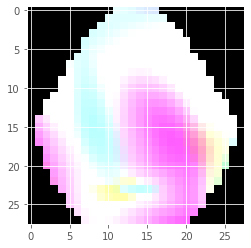

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[1110])

In [14]:

import keras
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10,shuffle=True)
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


In [15]:
y_train.shape

(3595, 2)

In [16]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (3595, 28, 28, 3)
3595 train samples
400 test samples


In [17]:
np.mean(x_train)

1.0000185

In [125]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 2
epochs = 10

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



from sklearn.model_selection import KFold
# Let's train the model using RMSprop
kf = KFold(n_splits=5, shuffle = True)
acc_row = []
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['categorical_accuracy'])

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #x_train /= 255
    #x_test /= 255
    print(y_train)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.1)

    loss, acc = model.evaluate(x_test,  y_test, verbose=2)
    acc_row.append(acc)
res = pd.DataFrame(acc_row)
res

[0. 0. 0. ... 1. 1. 1.]
Train on 2876 samples, validate on 320 samples
Epoch 1/10
2876/2876 [==============================] - 1s 514us/step - loss: 0.6890 - categorical_accuracy: 0.5542 - val_loss: 0.8392 - val_categorical_accuracy: 0.0125
Epoch 2/10
2876/2876 [==============================] - 1s 422us/step - loss: 0.6780 - categorical_accuracy: 0.5723 - val_loss: 0.7492 - val_categorical_accuracy: 0.2688
Epoch 3/10
 448/2876 [===>..........................] - ETA: 0s - loss: 0.6836 - categorical_accuracy: 0.5536

KeyboardInterrupt: 

In [19]:
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import metrics

batch_size = 32
num_classes = 2
epochs = 50
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# convert class vectors to binary class matrices


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.000001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print(y_train)
checkpointer = ModelCheckpoint(filepath='./checkpoint.h5', verbose=1,
                               save_best_only=True)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)




loss, acc = model.evaluate(x_test,  y_test, verbose=2)
acc_row.append(acc)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Train on 3235 samples, validate on 360 samples
Epoch 1/50
3235/3235 [==============================] - 4s 1ms/step - loss: 0.7212 - categorical_accuracy: 0.4961 - val_loss: 0.6996 - val_categorical_accuracy: 0.5222
Epoch 2/50
3235/3235 [==============================] - 1s 400us/step - loss: 0.7137 - categorical_accuracy: 0.5085 - val_loss: 0.7013 - val_categorical_accuracy: 0.4944
Epoch 3/50
3235/3235 [==============================] - 1s 403us/step - loss: 0.7081 - categorical_accuracy: 0.5051 - val_loss: 0.7026 - val_categorical_accuracy: 0.4944
Epoch 4/50
3235/3235 [==============================] - 1s 410us/step - loss: 0.7044 - categorical_accuracy: 0.5094 - val_loss: 0.7030 - val_categorical_accuracy: 0.4722
Epoch 5/50
3235/3235 [==============================] - 1s 404us/step - loss: 0.7016 - categorical_accuracy: 0.5066 - val_loss: 0.7040 - val_categorical_accuracy: 0.4694
Epoch 6/50
3235/3235 [=======================

3235/3235 [==============================] - 1s 402us/step - loss: 0.6853 - categorical_accuracy: 0.5267 - val_loss: 0.6974 - val_categorical_accuracy: 0.4667
Epoch 49/50
3235/3235 [==============================] - 1s 401us/step - loss: 0.6852 - categorical_accuracy: 0.5240 - val_loss: 0.6974 - val_categorical_accuracy: 0.4639
Epoch 50/50
3235/3235 [==============================] - 1s 399us/step - loss: 0.6852 - categorical_accuracy: 0.5221 - val_loss: 0.6973 - val_categorical_accuracy: 0.4722


NameError: name 'pickle' is not defined

In [22]:
model.save('path_to_my_model.h5')

In [3]:
from test_pipeline import TestPipelineEEG
import pandas as pd
data = pd.read_csv('full_data_shuffle_26_04_3999.csv')
predictor = TestPipelineEEG(image_size = 28, frame_duration = 0.78, overlap = 0.0, model_path = 'path_to_my_model.h5')
lst = []
for i in range(5):
    frame = data[data['sample_num'] == 0].drop(['Unnamed: 0', 'sample_num', 'gesture'], axis = 1)
    frame.columns = range(14)
    lst.append(predictor.evaluate(frame))
print(lst)

[0, 0, 0, 0, 0]


Generating training data...
Processing session:  data/data_0_test.csv . ( 1  of  2 )
247  frames generated with label  1 .247Interpolating 71/247Interpolating 108/247Interpolating 145/247Interpolating 182/247


Processing session:  data/data_1_test.csv . ( 2  of  2 )
Interpolating 190/198nterpolating 38/198Interpolating 77/198Interpolating 116/198Interpolating 154/198

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


198  frames generated with label  0 .




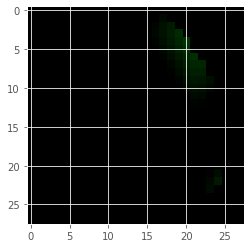

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


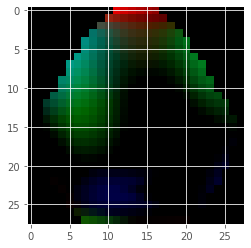

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


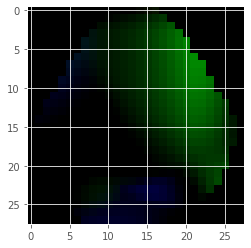

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


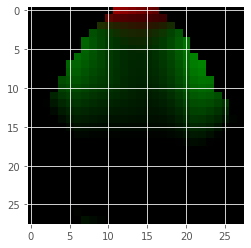

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


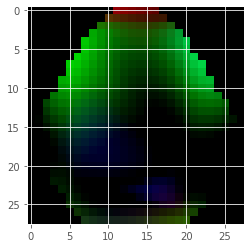

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


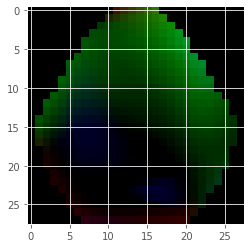

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


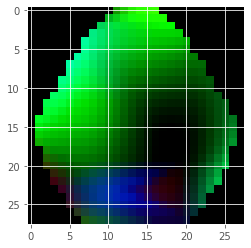

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


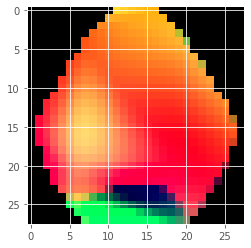

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


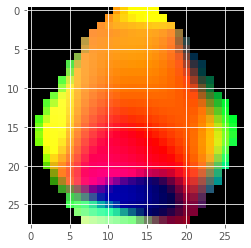

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


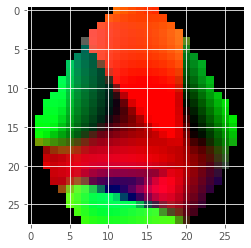

-0.033563893
445/445 [==============================] - 0s 189us/step


[1.4237568855285645, 0.5595505833625793]

In [96]:

scaler_list_dump[1] = scaler_list_dump[0] 
file_names = ['data/data_0_test.csv',
              'data/data_1_test.csv']
labels = [1,0]
image_size = 28
frame_duration = 0.78
overlap = 0.0
X_val, y_val,_= make_data_pipeline(file_names,labels,image_size,frame_duration,overlap, train=False, scaler_list_dump_list = scaler_list_dump)

for i in range(10):
    plt.imshow(X_val[i])
    plt.show()
y_val =keras.utils.to_categorical(y_val, num_classes)

X_val = X_val.astype('float32')
#x_test = x_test.astype('float32')
print(np.mean(X_val))
model.evaluate(X_val, y_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


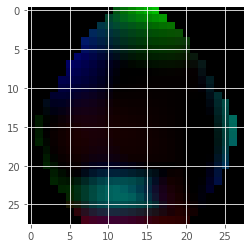

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


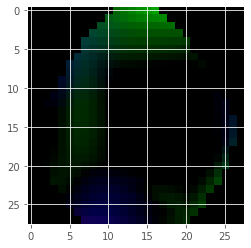

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


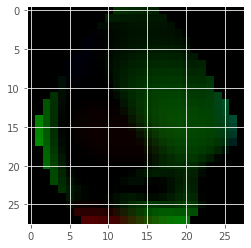

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


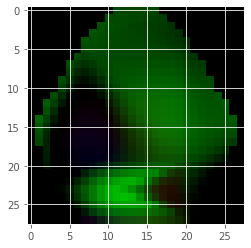

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


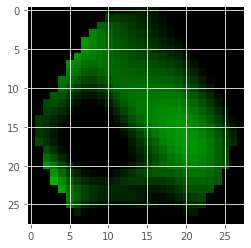

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


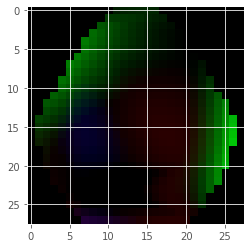

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


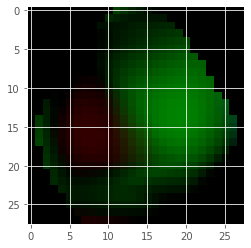

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


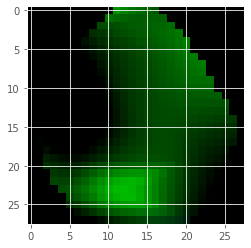

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


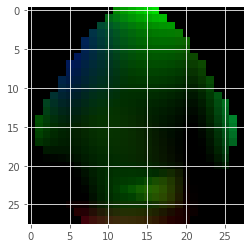

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


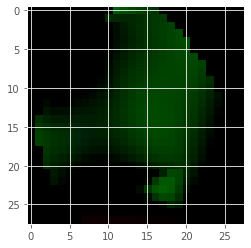

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


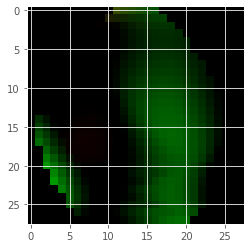

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


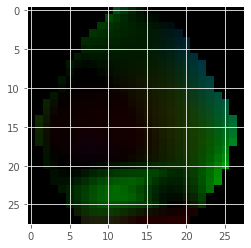

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


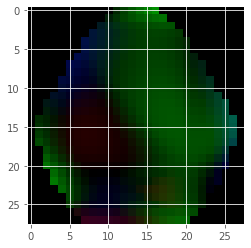

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


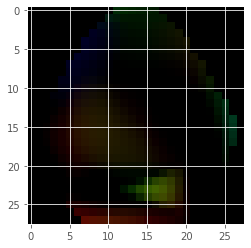

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


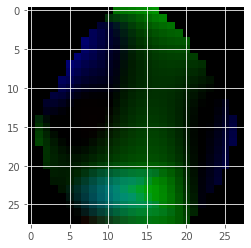

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


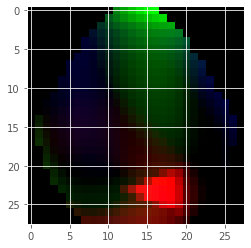

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


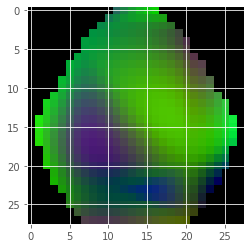

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


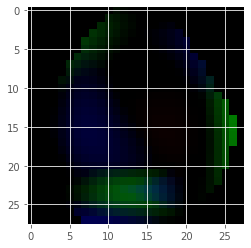

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


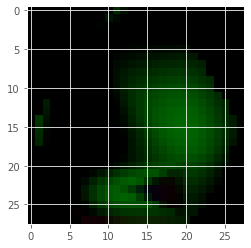

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


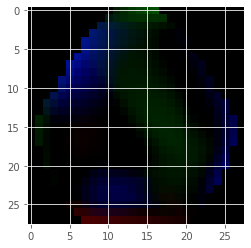

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


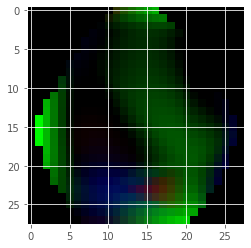

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


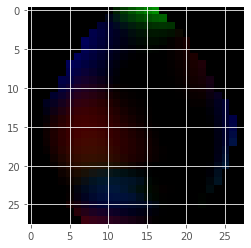

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


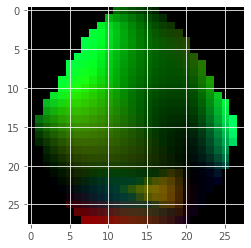

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


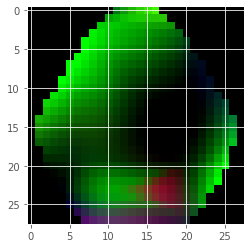

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


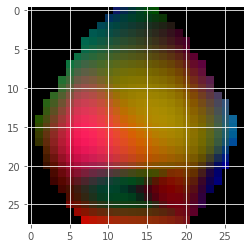

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


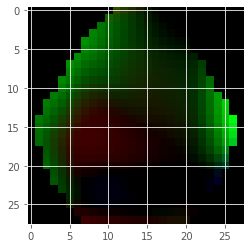

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


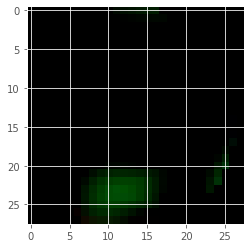

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


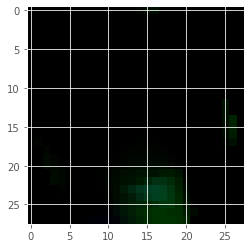

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


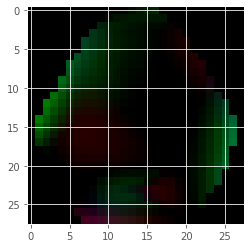

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


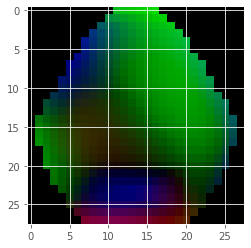

In [76]:
for i in range(30):
    plt.imshow(X[i])
    plt.show()
y_val =keras.utils.to_categorical(y_val, num_classes)